In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, LSTM, GRU, RNN, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from logger import init_logging
from base_module import MModule
from data import MDataset, Graph, load_graphs
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, GraphNode, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, pad_np_vectors
import base_module
from executor import single_train_loop, nested_detach, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging, logging
import logger
import gcn
from gcn import GCNLayer
import transformer
from transformer import TransformerModel
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
reload(gcn)
reload(transformer)
init_logging()

datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs
datasets_path: /root/guohao/DLT-perf-model/datasets
configs_path: /root/guohao/DLT-perf-model/notebooks/configs


In [3]:
dataset_environment_str = "P4_CPUALL"
scaler_cls = StandardScaler  # MinMaxScaler
dummy = False
model_type = ModelType.LSTM
method_prefix = "SubgraphBased"
eval_size = 200_000
train_size = 1000_000
epoch = 50
eval_step = 5000
# T4_CPUALL
meta_model_path = 'ckpts/meta/LSTM/meta_train2024-01-04_17-19-49/ckpt_900.pth'
scalers = None
eval_graphs = None
transfer_configs = [
    {
        "greeze_layers": [1, 3],
        "reinit_proj": True
    },
    {
        "greeze_layers": [1, 3],
        "reinit_proj": False
    },
    {
        "greeze_layers": [2, 4],
        "reinit_proj": True
    },
    {
        "greeze_layers": [2, 4],
        "reinit_proj": False
    },
    {
        "greeze_layers": [1, 2],
        "reinit_proj": True
    },
    {
        "greeze_layers": [1, 2],
        "reinit_proj": False
    },
    {
        "greeze_layers": [3, 4],
        "reinit_proj": True
    },
    {
        "greeze_layers": [3, 4],
        "reinit_proj": False
    }
]

In [4]:
def get_scalers(raw_train_ds: MDataset):

    def _preprocess_required_data(ds: MDataset):
        x_subgraph_feature_array = list()
        y_nodes_durations_array = list()
        y_subgraph_durations_array = list()

        for data in ds:
            feature, label = data
            x_subgraph_feature = feature["x_subgraph_feature"]
            assert isinstance(x_subgraph_feature, list)
            x_subgraph_feature_array.extend(x_subgraph_feature)

            y_nodes_durations = label["y_nodes_durations"]
            assert isinstance(y_nodes_durations, list)
            y_nodes_durations_array.extend(y_nodes_durations)

            y_subgraph_durations = label["y_subgraph_durations"]
            y_subgraph_durations_array.append(y_subgraph_durations)

        x_subgraph_feature_array = np.array(x_subgraph_feature_array)
        y_nodes_durations_array = np.array(y_nodes_durations_array)
        y_subgraph_durations_array = np.array(y_subgraph_durations_array)
        return [x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array]

    x_subgraph_feature_array, y_nodes_durations_array, y_subgraph_durations_array = _preprocess_required_data(
        ds=raw_train_ds)

    x_subgraph_feature_scaler = scaler_cls()
    x_subgraph_feature_scaler.fit(x_subgraph_feature_array)

    y_nodes_durations_scaler = scaler_cls()
    y_nodes_durations_scaler.fit(y_nodes_durations_array)

    y_subgraph_durations_scaler = scaler_cls()
    y_subgraph_durations_scaler.fit(y_subgraph_durations_array)

    return x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler


def subgraph_features(graph: Graph, subgraph_node_size: int = 10, step: int = 5, dataset_params: Dict = {}) -> \
        Tuple[List[Dict], List[Dict]]:
    subgraphs, _ = graph.subgraphs(
        subgraph_node_size=subgraph_node_size, step=step)
    X, Y = list(), list()

    def subgraph_feature(nodes: List[GraphNode]):
        feature_matrix = list()
        for node in nodes:
            feature = node.op.to_feature_array(
                mode=dataset_params.get("mode", "complex"))
            feature = np.array(feature)
            feature_matrix.append(feature)

        feature_matrix = pad_np_vectors(feature_matrix)
        feature_matrix = np.array(feature_matrix)

        adj_matrix = [
            [0.] * len(nodes) for _ in range(len(nodes))
        ]
        for curr_idx, node in enumerate(nodes):
            if curr_idx + 1 < len(nodes):
                adj_matrix[curr_idx][curr_idx+1] = 1.

        adj_matrix = np.array(adj_matrix)
        # x
        feature = {
            "x_graph_id": graph.ID,
            "x_node_ids": "|".join([str(node.node_id) for node in nodes]),
            "x_subgraph_feature": feature_matrix,
            "x_adj_matrix": adj_matrix
        }

        # y
        subgraph_duration = sum(node.duration + node.gap for node in subgraph)
        nodes_durations = list()
        for node in subgraph:
            node_duration_label = (
                node.duration, node.gap
            )
            nodes_durations.append(node_duration_label)

        label = {
            "y_graph_id": graph.ID,
            "y_nodes_durations": nodes_durations,
            "y_subgraph_durations": (subgraph_duration,)
        }

        return feature, label

    for i, subgraph in enumerate(subgraphs):
        x, y = subgraph_feature(subgraph)
        X.append(x)
        Y.append(y)

    return X, Y


def init_dataset(graphs: List[Graph], conf) -> MDataset:
    X = list()
    Y = list()

    subgraph_feature_maxsize = 0

    for graph in graphs:
        X_, Y_ = subgraph_features(graph=graph,
                                   subgraph_node_size=conf.dataset_subgraph_node_size,
                                   step=conf.dataset_subgraph_step,
                                   dataset_params=conf.dataset_params)
        for x in X_:
            subgraph_feature_size = len(x["x_subgraph_feature"][0])
            subgraph_feature_maxsize = max(
                subgraph_feature_maxsize, subgraph_feature_size)

        X.extend(X_)
        Y.extend(Y_)

    for x in X:
        x["x_subgraph_feature"] = pad_np_vectors(
            x["x_subgraph_feature"], maxsize=subgraph_feature_maxsize)

    dataset = MDataset(X, Y)
    return dataset

In [5]:

def preprocess_dataset(ds: MDataset, scalers) -> MDataset:
    x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers

    processed_features = list()
    processed_labels = list()

    for data in ds:
        feature, label = data
        x_subgraph_feature = feature["x_subgraph_feature"]
        assert isinstance(x_subgraph_feature, list)
        x_subgraph_feature = np.array(x_subgraph_feature).astype(np.float32)
        transformed_x_subgraph_feature = x_subgraph_feature_scaler.transform(
            x_subgraph_feature)

        x_adj_matrix = feature["x_adj_matrix"]
        x_adj_matrix = np.array(x_adj_matrix).astype(np.float32)

        y_nodes_durations = label["y_nodes_durations"]
        assert isinstance(y_nodes_durations, list)
        y_nodes_durations = np.array(y_nodes_durations).astype(np.float32)
        transformed_y_nodes_durations = y_nodes_durations_scaler.transform(
            y_nodes_durations)

        y_subgraph_durations = label["y_subgraph_durations"]
        y_subgraph_durations_array = (y_subgraph_durations,)
        y_subgraph_durations_array = y_subgraph_durations_scaler.transform(
            y_subgraph_durations_array)
        transformed_y_subgraph_durations = y_subgraph_durations_array[0]

        processed_features.append({
            "x_graph_id": feature["x_graph_id"],
            "x_node_ids": feature["x_node_ids"],
            "x_subgraph_feature": torch.Tensor(transformed_x_subgraph_feature),
            "x_adj_matrix": torch.Tensor(x_adj_matrix)
        })

        processed_labels.append({
            "y_graph_id": label["y_graph_id"],
            "y_nodes_durations": torch.Tensor(transformed_y_nodes_durations),
            "y_subgraph_durations": torch.Tensor(transformed_y_subgraph_durations)
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

In [6]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    def compute_graph_nodes_durations(outputs_, node_ids_str_):
        x_subgraph_feature_scaler, y_nodes_durations_scaler, y_subgraph_durations_scaler = scalers
        node_to_durations = defaultdict(list)
        for i, output_ in enumerate(outputs_):
            node_ids = node_ids_str_[i]
            node_ids_ = node_ids.split("|")
            assert len(output_) == len(node_ids_)
            transformed: np.ndarray = y_nodes_durations_scaler.inverse_transform(
                output_)
            for i, node_id in enumerate(node_ids_):
                node_to_durations[node_id].append(np.sum(transformed[i]))
        node_to_duration = {k: np.average(v)
                            for k, v in node_to_durations.items()}
        return node_to_duration

    graph_id_to_node_to_duration = defaultdict(lambda: defaultdict(list))
    for inputs, outputs in zip(input_batches, output_batches):
        outputs = nested_detach(outputs)
        outputs = outputs.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        graph_groups = defaultdict(list)
        for i, graph_id in enumerate(graph_ids):
            graph_groups[graph_id].append(i)

        for graph_id, indices in graph_groups.items():
            group_x_node_ids = [v for i, v in enumerate(
                inputs["x_node_ids"]) if i in indices]
            group_outputs = [v for i, v in enumerate(outputs) if i in indices]
            node_to_durations = compute_graph_nodes_durations(
                group_outputs, group_x_node_ids)
            for node, duration in node_to_durations.items():
                graph_id_to_node_to_duration[graph_id][node].append(duration)
    graph_id_to_duration_pred = dict()
    # TODO check this!!!
    for graph_id, node_to_duration in graph_id_to_node_to_duration.items():
        duration_pred = 0
        for _, duration_preds in node_to_duration.items():
            duration_pred += np.average(duration_preds)
        graph_id_to_duration_pred[graph_id] = duration_pred
    duration_metrics = MetricUtil.compute_duration_metrics(
        eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}

In [7]:

def to_device(conf: Config, features, labels):
    features['x_subgraph_feature'] = features['x_subgraph_feature'].to(
        conf.device)
    features['x_adj_matrix'] = features['x_adj_matrix'].to(conf.device)
    labels['y_nodes_durations'] = labels['y_nodes_durations'].to(conf.device)
    labels['y_subgraph_durations'] = labels['y_subgraph_durations'].to(
        conf.device)
    return features, labels

In [8]:

class LSTMModel(MModule):
    def __init__(self, feature_size, nodes_durations_len, num_layers, bidirectional, **kwargs):
        super().__init__(**kwargs)
        self.lstm = LSTM(input_size=feature_size, hidden_size=feature_size, num_layers=num_layers, batch_first=True,
                         bidirectional=bidirectional)
        num_directions = 2 if bidirectional else 1
        self.project = torch.nn.Linear(
            in_features=feature_size * num_directions, out_features=nodes_durations_len)
        self.loss_fn = L1Loss()

    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "num_layers": [4, 6, 8],
            "bidirectional": [True, False],
            "learning_rate": [1e-4, 1e-5],
            'batch_size': [32, 64],
            'epochs': [20],
            'optimizer': ['Adam', 'SGD'],
        }

    def forward(self, X):
        X = X["x_subgraph_feature"]
        out, _ = self.lstm(X)
        Y = self.project(out)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_nodes_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss

    def prepare_transfer(self, freeze_layers: list | None = None, reinit_proj: bool = True, **kwargs):
        print("prepare_transfer")
        if freeze_layers is not None:
            layers = self.lstm.layers
            if freeze_layers > len(layers):
                raise ValueError(
                    f"freeze_layers ({freeze_layers}) must be less than the number of layers ")
            for layer_idx in range(freeze_layers):
                for param in layers[layer_idx].parameters():
                    param.requires_grad = False
        if reinit_proj:
            self.project.reset_parameters()


def init_LSTM_model() -> MModule | Any:
    def default_model_params() -> Dict[str, Any]:
        return {
            "num_layers": 4,
            "bidirectional": True,
        }
    x_node_feature_size = 66
    y_nodes_durations_len = 2
    print(x_node_feature_size, y_nodes_durations_len)
    model_params = {}
    final_params = default_model_params()
    for k, v in final_params.items():
        final_params[k] = model_params.get(k, v)
    print(final_params)
    return LSTMModel(
        feature_size=x_node_feature_size,
        nodes_durations_len=y_nodes_durations_len,
        **final_params
    )

In [9]:
conf = Config.from_dict({
    "model": "LSTM",
    "dataset_environment_str": dataset_environment_str,
    "meta_dataset_environment_strs": [dataset_environment_str],
    "dataset_subgraph_node_size": 12,
    "dataset_subgraph_step": 3,
    "all_seed": 42,
    "dataset_params": {
        "duration_summed": False,
    },
    "model_params": {
        "num_layers": 4,
        "bidirectional": True
    },
    "dataset_dummy": False,
    "batch_size": 128,
    "eval_steps": eval_step,
    "learning_rate": 0.001,
    "epochs": epoch,
    "optimizer": "Adam",
    "train_size": train_size,
    "eval_size": eval_size,
    "meta_configs": {
        "learning_rate": 0.005,
        "meta_learning_rate": 0.001,
        "meta_train_steps": 1000,
        "meta_task_per_step": 8,
        "meta_fast_adaption_step": 5,
        "meta_dataset_train_environment_strs": [dataset_environment_str],
        "meta_dataset_eval_environment_strs": [dataset_environment_str],
    },
})
eval_graphs = load_graphs(dataset_environment_str,
                          train_or_eval="eval",
                          use_dummy=dummy,
                          max_row=eval_size)
train_graphs = load_graphs(dataset_environment_str,
                           train_or_eval="train",
                           use_dummy=dummy,
                           max_row=train_size)  # todo 500
print(len(train_graphs), len(eval_graphs))
train_ds = init_dataset(train_graphs, conf)
eval_ds = init_dataset(eval_graphs, conf)
scalers = get_scalers(train_ds)
preprocessed_train_ds = preprocess_dataset(train_ds, scalers)
preprocessed_eval_ds = preprocess_dataset(eval_ds, scalers)

[2024-01-08 11:32:33,527] {data.py:448} INFO - Loading graphs eval
[2024-01-08 11:32:33,529] {data.py:419} INFO - Loading merged.csv
[2024-01-08 11:32:33,529] {data.py:419} INFO - Loading merged.csv
[2024-01-08 11:32:33,551] {data.py:422} INFO - Loaded merged.csv, 10000 rows
[2024-01-08 11:32:33,816] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.181_7.csv, 849 rows
[2024-01-08 11:32:34,078] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.88_7.csv, 847 rows
[2024-01-08 11:32:34,340] {data.py:428} INFO - Loaded shufflenet_v2_x1_5.159_7.csv, 849 rows
[2024-01-08 11:32:34,718] {data.py:428} INFO - Loaded rand_6000.144_7.csv, 1218 rows
[2024-01-08 11:32:34,979] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.220_7.csv, 849 rows
[2024-01-08 11:32:35,190] {data.py:428} INFO - Loaded rand_5000.50_7.csv, 683 rows
[2024-01-08 11:32:35,543] {data.py:428} INFO - Loaded rand_3500.9_7.csv, 683 rows
[2024-01-08 11:32:35,803] {data.py:428} INFO - Loaded shufflenet_v2_x0_5.127_7.csv, 849 rows
[2024-01-0

MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:32:48,193] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:32:48,195] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:32:48,336] {executor.py:114} INFO - ModelType.LSTM trained for 0.142076324 seconds.
[2024-01-08 11:32:48,337] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:32:48,722] {executor.py:120} INFO - ModelType.LSTM train loss: 0.28301510214805603, eval metrics: {'eval_loss': 0.38215839175077587, 'MRE': 0.6394215938825225, 'MAE': 0.6796665573966281, 'RMSE': 319.887986857371}
[2024-01-08 11:32:48,724] {executor.py:363} INFO - Saving model at step 0 with loss 0.28301510214805603,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-32-48


100%|██████████| 26/26 [00:00<00:00, 38.47it/s]

[2024-01-08 11:32:48,875] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 141.99it/s]

[2024-01-08 11:32:49,063] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 134.97it/s]

[2024-01-08 11:32:49,261] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 137.51it/s]

[2024-01-08 11:32:49,455] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 134.97it/s]

[2024-01-08 11:32:49,652] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 137.36it/s]

[2024-01-08 11:32:49,847] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 136.02it/s]

[2024-01-08 11:32:50,043] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 137.22it/s]

[2024-01-08 11:32:50,237] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 131.56it/s]

[2024-01-08 11:32:50,440] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 137.64it/s]

[2024-01-08 11:32:50,633] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 136.81it/s]

[2024-01-08 11:32:50,828] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 137.21it/s]

[2024-01-08 11:32:51,023] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 136.63it/s]

[2024-01-08 11:32:51,218] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 136.72it/s]

[2024-01-08 11:32:51,413] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 135.50it/s]

[2024-01-08 11:32:51,610] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 135.93it/s]

[2024-01-08 11:32:51,806] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 135.39it/s]

[2024-01-08 11:32:52,003] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 135.07it/s]

[2024-01-08 11:32:52,201] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 134.12it/s]

[2024-01-08 11:32:52,400] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 132.43it/s]


[2024-01-08 11:32:52,601] {executor.py:323} INFO - ModelType.LSTM training epoch 20


100%|██████████| 26/26 [00:00<00:00, 134.53it/s]

[2024-01-08 11:32:52,799] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 136.71it/s]

[2024-01-08 11:32:52,995] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 138.08it/s]

[2024-01-08 11:32:53,188] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 136.20it/s]

[2024-01-08 11:32:53,384] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 134.85it/s]

[2024-01-08 11:32:53,581] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 136.38it/s]

[2024-01-08 11:32:53,777] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 135.79it/s]

[2024-01-08 11:32:53,973] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 134.97it/s]

[2024-01-08 11:32:54,171] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 135.94it/s]

[2024-01-08 11:32:54,368] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 137.02it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:32:54,709] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:32:54,710] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:32:54,717] {executor.py:114} INFO - ModelType.LSTM trained for 0.008114975 seconds.
[2024-01-08 11:32:54,718] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:32:55,103] {executor.py:120} INFO - ModelType.LSTM train loss: 0.19103598594665527, eval metrics: {'eval_loss': 0.20203673796584973, 'MRE': 0.40163653369646785, 'MAE': 0.4264462671585558, 'RMSE': 220.5681797801669}
[2024-01-08 11:32:55,104] {executor.py:363} INFO - Saving model at step 0 with loss 0.19103598594665527,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-32-54


100%|██████████| 26/26 [00:00<00:00, 47.62it/s]

[2024-01-08 11:32:55,260] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 139.15it/s]

[2024-01-08 11:32:55,451] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 134.92it/s]

[2024-01-08 11:32:55,649] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 136.65it/s]

[2024-01-08 11:32:55,844] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 134.54it/s]

[2024-01-08 11:32:56,042] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 132.34it/s]

[2024-01-08 11:32:56,244] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 136.22it/s]

[2024-01-08 11:32:56,440] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 136.72it/s]

[2024-01-08 11:32:56,635] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 134.20it/s]

[2024-01-08 11:32:56,833] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 139.09it/s]

[2024-01-08 11:32:57,025] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 135.15it/s]

[2024-01-08 11:32:57,223] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 136.34it/s]

[2024-01-08 11:32:57,418] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 134.54it/s]

[2024-01-08 11:32:57,617] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 136.93it/s]

[2024-01-08 11:32:57,811] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 138.58it/s]

[2024-01-08 11:32:58,004] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 134.81it/s]

[2024-01-08 11:32:58,202] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 133.18it/s]

[2024-01-08 11:32:58,402] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 136.29it/s]

[2024-01-08 11:32:58,598] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 138.23it/s]

[2024-01-08 11:32:58,791] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 136.63it/s]

[2024-01-08 11:32:58,986] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 26/26 [00:00<00:00, 135.23it/s]

[2024-01-08 11:32:59,183] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 135.61it/s]

[2024-01-08 11:32:59,380] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 136.04it/s]

[2024-01-08 11:32:59,576] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 137.49it/s]

[2024-01-08 11:32:59,770] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 133.86it/s]

[2024-01-08 11:32:59,969] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 132.32it/s]

[2024-01-08 11:33:00,170] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 136.70it/s]

[2024-01-08 11:33:00,366] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 135.19it/s]

[2024-01-08 11:33:00,563] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 136.20it/s]

[2024-01-08 11:33:00,758] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 137.31it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:01,095] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:01,096] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:01,103] {executor.py:114} INFO - ModelType.LSTM trained for 0.008153516 seconds.
[2024-01-08 11:33:01,104] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:01,487] {executor.py:120} INFO - ModelType.LSTM train loss: 0.3639659881591797, eval metrics: {'eval_loss': 0.3796763726725028, 'MRE': 0.39698242775608283, 'MAE': 0.4473128838338945, 'RMSE': 239.4740328791136}
[2024-01-08 11:33:01,489] {executor.py:363} INFO - Saving model at step 0 with loss 0.3639659881591797,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-01


100%|██████████| 26/26 [00:00<00:00, 48.47it/s]

[2024-01-08 11:33:01,636] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 146.39it/s]

[2024-01-08 11:33:01,819] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 139.66it/s]

[2024-01-08 11:33:02,010] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 139.68it/s]

[2024-01-08 11:33:02,201] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 138.90it/s]

[2024-01-08 11:33:02,393] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 136.19it/s]

[2024-01-08 11:33:02,589] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 135.85it/s]

[2024-01-08 11:33:02,785] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 137.43it/s]

[2024-01-08 11:33:02,979] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 135.67it/s]

[2024-01-08 11:33:03,176] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 136.71it/s]

[2024-01-08 11:33:03,371] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 137.82it/s]

[2024-01-08 11:33:03,565] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 135.11it/s]

[2024-01-08 11:33:03,762] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 136.05it/s]

[2024-01-08 11:33:03,958] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 136.53it/s]

[2024-01-08 11:33:04,153] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 137.03it/s]

[2024-01-08 11:33:04,348] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 137.15it/s]

[2024-01-08 11:33:04,543] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 135.97it/s]

[2024-01-08 11:33:04,739] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 135.23it/s]

[2024-01-08 11:33:04,936] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 136.72it/s]

[2024-01-08 11:33:05,131] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 136.14it/s]

[2024-01-08 11:33:05,327] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 26/26 [00:00<00:00, 134.72it/s]

[2024-01-08 11:33:05,525] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 136.24it/s]

[2024-01-08 11:33:05,721] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 135.04it/s]

[2024-01-08 11:33:05,919] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 136.23it/s]

[2024-01-08 11:33:06,114] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 136.57it/s]

[2024-01-08 11:33:06,310] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 136.97it/s]

[2024-01-08 11:33:06,505] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 132.87it/s]

[2024-01-08 11:33:06,705] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 136.40it/s]

[2024-01-08 11:33:06,901] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 135.87it/s]

[2024-01-08 11:33:07,097] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 133.73it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:07,444] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:07,445] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:07,452] {executor.py:114} INFO - ModelType.LSTM trained for 0.008168891 seconds.
[2024-01-08 11:33:07,453] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:07,837] {executor.py:120} INFO - ModelType.LSTM train loss: 0.1530798226594925, eval metrics: {'eval_loss': 0.21452410648075435, 'MRE': 0.43230694741384035, 'MAE': 0.4661977795077681, 'RMSE': 236.33013802153434}
[2024-01-08 11:33:07,839] {executor.py:363} INFO - Saving model at step 0 with loss 0.1530798226594925,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-07


100%|██████████| 26/26 [00:00<00:00, 49.19it/s]

[2024-01-08 11:33:07,977] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 144.35it/s]

[2024-01-08 11:33:08,162] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 139.18it/s]

[2024-01-08 11:33:08,354] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 137.87it/s]

[2024-01-08 11:33:08,547] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 137.71it/s]

[2024-01-08 11:33:08,741] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 136.74it/s]

[2024-01-08 11:33:08,936] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 136.55it/s]

[2024-01-08 11:33:09,131] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 137.13it/s]

[2024-01-08 11:33:09,326] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 137.47it/s]

[2024-01-08 11:33:09,520] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 139.72it/s]

[2024-01-08 11:33:09,711] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 139.71it/s]

[2024-01-08 11:33:09,902] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 139.89it/s]

[2024-01-08 11:33:10,093] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 140.18it/s]

[2024-01-08 11:33:10,283] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 134.80it/s]

[2024-01-08 11:33:10,482] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 135.14it/s]

[2024-01-08 11:33:10,679] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 137.22it/s]

[2024-01-08 11:33:10,873] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 135.72it/s]

[2024-01-08 11:33:11,070] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 136.62it/s]

[2024-01-08 11:33:11,265] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 134.32it/s]

[2024-01-08 11:33:11,464] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 137.97it/s]

[2024-01-08 11:33:11,657] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 26/26 [00:00<00:00, 135.30it/s]

[2024-01-08 11:33:11,854] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 136.64it/s]

[2024-01-08 11:33:12,050] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 137.41it/s]

[2024-01-08 11:33:12,244] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 137.09it/s]

[2024-01-08 11:33:12,439] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 137.35it/s]

[2024-01-08 11:33:12,633] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 135.82it/s]

[2024-01-08 11:33:12,829] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 135.20it/s]

[2024-01-08 11:33:13,027] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 134.38it/s]


[2024-01-08 11:33:13,226] {executor.py:323} INFO - ModelType.LSTM training epoch 28


100%|██████████| 26/26 [00:00<00:00, 136.20it/s]

[2024-01-08 11:33:13,423] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 133.48it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:13,970] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:13,971] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:13,979] {executor.py:114} INFO - ModelType.LSTM trained for 0.00907436 seconds.
[2024-01-08 11:33:13,980] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:14,368] {executor.py:120} INFO - ModelType.LSTM train loss: 0.3841017186641693, eval metrics: {'eval_loss': 0.43155165303211945, 'MRE': 0.3166579042528611, 'MAE': 0.34172052337344544, 'RMSE': 189.54832098995584}
[2024-01-08 11:33:14,370] {executor.py:363} INFO - Saving model at step 0 with loss 0.3841017186641693,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-13


100%|██████████| 26/26 [00:00<00:00, 48.73it/s]

[2024-01-08 11:33:14,509] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 144.90it/s]

[2024-01-08 11:33:14,694] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 134.77it/s]

[2024-01-08 11:33:14,893] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 132.67it/s]

[2024-01-08 11:33:15,095] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 132.90it/s]

[2024-01-08 11:33:15,296] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 134.78it/s]

[2024-01-08 11:33:15,494] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 135.75it/s]

[2024-01-08 11:33:15,690] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 136.24it/s]

[2024-01-08 11:33:15,886] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 136.65it/s]

[2024-01-08 11:33:16,081] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 137.06it/s]

[2024-01-08 11:33:16,276] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 136.29it/s]

[2024-01-08 11:33:16,472] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 134.38it/s]

[2024-01-08 11:33:16,670] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 135.97it/s]

[2024-01-08 11:33:16,867] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 135.41it/s]

[2024-01-08 11:33:17,064] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 132.35it/s]

[2024-01-08 11:33:17,265] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 136.52it/s]

[2024-01-08 11:33:17,461] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 134.62it/s]

[2024-01-08 11:33:17,659] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 132.80it/s]


[2024-01-08 11:33:17,860] {executor.py:323} INFO - ModelType.LSTM training epoch 18


100%|██████████| 26/26 [00:00<00:00, 137.35it/s]

[2024-01-08 11:33:18,054] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 132.54it/s]


[2024-01-08 11:33:18,256] {executor.py:323} INFO - ModelType.LSTM training epoch 20


100%|██████████| 26/26 [00:00<00:00, 137.08it/s]

[2024-01-08 11:33:18,450] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 134.86it/s]

[2024-01-08 11:33:18,648] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 136.05it/s]

[2024-01-08 11:33:18,844] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 132.60it/s]


[2024-01-08 11:33:19,045] {executor.py:323} INFO - ModelType.LSTM training epoch 24


100%|██████████| 26/26 [00:00<00:00, 135.79it/s]

[2024-01-08 11:33:19,242] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 136.57it/s]

[2024-01-08 11:33:19,438] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 132.67it/s]


[2024-01-08 11:33:19,639] {executor.py:323} INFO - ModelType.LSTM training epoch 27


100%|██████████| 26/26 [00:00<00:00, 135.53it/s]

[2024-01-08 11:33:19,836] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 136.17it/s]

[2024-01-08 11:33:20,032] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 136.74it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:20,369] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:20,370] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:20,377] {executor.py:114} INFO - ModelType.LSTM trained for 0.008205558 seconds.
[2024-01-08 11:33:20,378] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:20,762] {executor.py:120} INFO - ModelType.LSTM train loss: 0.17191466689109802, eval metrics: {'eval_loss': 0.20577329741074488, 'MRE': 0.43553783668486307, 'MAE': 0.46081909927537235, 'RMSE': 235.35907882977995}
[2024-01-08 11:33:20,764] {executor.py:363} INFO - Saving model at step 0 with loss 0.17191466689109802,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-20


100%|██████████| 26/26 [00:00<00:00, 48.01it/s]

[2024-01-08 11:33:20,915] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 147.60it/s]

[2024-01-08 11:33:21,096] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 135.97it/s]

[2024-01-08 11:33:21,292] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 137.39it/s]

[2024-01-08 11:33:21,487] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 136.06it/s]

[2024-01-08 11:33:21,683] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 136.42it/s]

[2024-01-08 11:33:21,879] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 138.58it/s]

[2024-01-08 11:33:22,071] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 134.68it/s]

[2024-01-08 11:33:22,270] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 135.47it/s]

[2024-01-08 11:33:22,466] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 136.65it/s]

[2024-01-08 11:33:22,662] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 135.05it/s]

[2024-01-08 11:33:22,859] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 137.32it/s]

[2024-01-08 11:33:23,054] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 136.39it/s]

[2024-01-08 11:33:23,249] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 136.85it/s]

[2024-01-08 11:33:23,444] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 137.21it/s]

[2024-01-08 11:33:23,639] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 137.03it/s]

[2024-01-08 11:33:23,833] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 135.96it/s]

[2024-01-08 11:33:24,029] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 136.84it/s]

[2024-01-08 11:33:24,224] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 135.01it/s]

[2024-01-08 11:33:24,422] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 137.37it/s]

[2024-01-08 11:33:24,616] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 26/26 [00:00<00:00, 135.47it/s]

[2024-01-08 11:33:24,813] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 135.50it/s]

[2024-01-08 11:33:25,010] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 138.03it/s]

[2024-01-08 11:33:25,204] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 135.17it/s]

[2024-01-08 11:33:25,401] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 133.24it/s]


[2024-01-08 11:33:25,601] {executor.py:323} INFO - ModelType.LSTM training epoch 25


100%|██████████| 26/26 [00:00<00:00, 137.49it/s]

[2024-01-08 11:33:25,795] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 135.60it/s]

[2024-01-08 11:33:25,992] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 135.56it/s]

[2024-01-08 11:33:26,189] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 134.44it/s]

[2024-01-08 11:33:26,388] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 133.67it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:26,723] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:26,724] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:26,731] {executor.py:114} INFO - ModelType.LSTM trained for 0.008344476 seconds.
[2024-01-08 11:33:26,732] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:27,121] {executor.py:120} INFO - ModelType.LSTM train loss: 0.4175492227077484, eval metrics: {'eval_loss': 0.39530816158423054, 'MRE': 0.37732230048575566, 'MAE': 0.4268613555355251, 'RMSE': 231.72375838869056}
[2024-01-08 11:33:27,122] {executor.py:363} INFO - Saving model at step 0 with loss 0.4175492227077484,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-26


100%|██████████| 26/26 [00:00<00:00, 47.62it/s]

[2024-01-08 11:33:27,273] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 143.16it/s]

[2024-01-08 11:33:27,460] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 137.06it/s]

[2024-01-08 11:33:27,654] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 136.40it/s]

[2024-01-08 11:33:27,850] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 136.87it/s]

[2024-01-08 11:33:28,045] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 136.69it/s]

[2024-01-08 11:33:28,240] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 135.88it/s]

[2024-01-08 11:33:28,436] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 136.27it/s]

[2024-01-08 11:33:28,632] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 136.65it/s]

[2024-01-08 11:33:28,827] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 137.33it/s]

[2024-01-08 11:33:29,022] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 138.69it/s]

[2024-01-08 11:33:29,214] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 125.70it/s]

[2024-01-08 11:33:29,426] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 130.33it/s]

[2024-01-08 11:33:29,630] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 126.50it/s]

[2024-01-08 11:33:29,840] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 127.49it/s]

[2024-01-08 11:33:30,049] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 127.68it/s]

[2024-01-08 11:33:30,257] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 128.88it/s]

[2024-01-08 11:33:30,464] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 127.11it/s]

[2024-01-08 11:33:30,673] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 127.15it/s]

[2024-01-08 11:33:30,881] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 129.99it/s]

[2024-01-08 11:33:31,086] {executor.py:323} INFO - ModelType.LSTM training epoch 20



100%|██████████| 26/26 [00:00<00:00, 129.56it/s]

[2024-01-08 11:33:31,292] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 129.74it/s]

[2024-01-08 11:33:31,497] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 129.67it/s]

[2024-01-08 11:33:31,702] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 129.24it/s]

[2024-01-08 11:33:31,909] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 126.84it/s]

[2024-01-08 11:33:32,118] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 127.32it/s]

[2024-01-08 11:33:32,327] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 127.83it/s]

[2024-01-08 11:33:32,536] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 124.33it/s]

[2024-01-08 11:33:32,749] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 126.34it/s]

[2024-01-08 11:33:32,960] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 130.20it/s]


MAML(
  (module): LSTMModel(
    (lstm): LSTM(66, 66, num_layers=4, batch_first=True, bidirectional=True)
    (project): Linear(in_features=132, out_features=2, bias=True)
    (loss_fn): L1Loss()
  )
)
transfer
/root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM
prepare_transfer
[2024-01-08 11:33:33,305] {executor.py:321} INFO - ModelType.LSTM start single training.
[2024-01-08 11:33:33,306] {executor.py:323} INFO - ModelType.LSTM training epoch 0


  0%|          | 0/26 [00:00<?, ?it/s]

[2024-01-08 11:33:33,313] {executor.py:114} INFO - ModelType.LSTM trained for 0.00813639 seconds.
[2024-01-08 11:33:33,314] {executor.py:115} INFO - ModelType.LSTM eval at step 0.
[2024-01-08 11:33:33,704] {executor.py:120} INFO - ModelType.LSTM train loss: 0.13694290816783905, eval metrics: {'eval_loss': 0.22624314862948197, 'MRE': 0.5506160170762938, 'MAE': 0.5759386076466726, 'RMSE': 275.4987880939013}
[2024-01-08 11:33:33,705] {executor.py:363} INFO - Saving model at step 0 with loss 0.13694290816783905,save path: /root/guohao/DLT-perf-model/notebooks/ckpts/transfer/P4_CPUALL/LSTM/single_train2024-01-08_11-33-33


100%|██████████| 26/26 [00:00<00:00, 46.99it/s]

[2024-01-08 11:33:33,863] {executor.py:323} INFO - ModelType.LSTM training epoch 1



100%|██████████| 26/26 [00:00<00:00, 135.90it/s]

[2024-01-08 11:33:34,059] {executor.py:323} INFO - ModelType.LSTM training epoch 2



100%|██████████| 26/26 [00:00<00:00, 127.75it/s]

[2024-01-08 11:33:34,267] {executor.py:323} INFO - ModelType.LSTM training epoch 3



100%|██████████| 26/26 [00:00<00:00, 126.45it/s]

[2024-01-08 11:33:34,477] {executor.py:323} INFO - ModelType.LSTM training epoch 4



100%|██████████| 26/26 [00:00<00:00, 128.29it/s]

[2024-01-08 11:33:34,684] {executor.py:323} INFO - ModelType.LSTM training epoch 5



100%|██████████| 26/26 [00:00<00:00, 129.36it/s]

[2024-01-08 11:33:34,890] {executor.py:323} INFO - ModelType.LSTM training epoch 6



100%|██████████| 26/26 [00:00<00:00, 130.28it/s]

[2024-01-08 11:33:35,095] {executor.py:323} INFO - ModelType.LSTM training epoch 7



100%|██████████| 26/26 [00:00<00:00, 129.44it/s]

[2024-01-08 11:33:35,300] {executor.py:323} INFO - ModelType.LSTM training epoch 8



100%|██████████| 26/26 [00:00<00:00, 129.63it/s]

[2024-01-08 11:33:35,506] {executor.py:323} INFO - ModelType.LSTM training epoch 9



100%|██████████| 26/26 [00:00<00:00, 126.75it/s]

[2024-01-08 11:33:35,716] {executor.py:323} INFO - ModelType.LSTM training epoch 10



100%|██████████| 26/26 [00:00<00:00, 127.11it/s]

[2024-01-08 11:33:35,924] {executor.py:323} INFO - ModelType.LSTM training epoch 11



100%|██████████| 26/26 [00:00<00:00, 125.96it/s]

[2024-01-08 11:33:36,135] {executor.py:323} INFO - ModelType.LSTM training epoch 12



100%|██████████| 26/26 [00:00<00:00, 131.47it/s]

[2024-01-08 11:33:36,338] {executor.py:323} INFO - ModelType.LSTM training epoch 13



100%|██████████| 26/26 [00:00<00:00, 125.40it/s]

[2024-01-08 11:33:36,550] {executor.py:323} INFO - ModelType.LSTM training epoch 14



100%|██████████| 26/26 [00:00<00:00, 126.28it/s]

[2024-01-08 11:33:36,760] {executor.py:323} INFO - ModelType.LSTM training epoch 15



100%|██████████| 26/26 [00:00<00:00, 125.15it/s]

[2024-01-08 11:33:36,972] {executor.py:323} INFO - ModelType.LSTM training epoch 16



100%|██████████| 26/26 [00:00<00:00, 129.29it/s]

[2024-01-08 11:33:37,181] {executor.py:323} INFO - ModelType.LSTM training epoch 17



100%|██████████| 26/26 [00:00<00:00, 133.16it/s]

[2024-01-08 11:33:37,384] {executor.py:323} INFO - ModelType.LSTM training epoch 18



100%|██████████| 26/26 [00:00<00:00, 134.32it/s]

[2024-01-08 11:33:37,583] {executor.py:323} INFO - ModelType.LSTM training epoch 19



100%|██████████| 26/26 [00:00<00:00, 130.90it/s]


[2024-01-08 11:33:37,787] {executor.py:323} INFO - ModelType.LSTM training epoch 20


100%|██████████| 26/26 [00:00<00:00, 115.24it/s]

[2024-01-08 11:33:38,017] {executor.py:323} INFO - ModelType.LSTM training epoch 21



100%|██████████| 26/26 [00:00<00:00, 116.81it/s]

[2024-01-08 11:33:38,245] {executor.py:323} INFO - ModelType.LSTM training epoch 22



100%|██████████| 26/26 [00:00<00:00, 122.73it/s]

[2024-01-08 11:33:38,461] {executor.py:323} INFO - ModelType.LSTM training epoch 23



100%|██████████| 26/26 [00:00<00:00, 130.16it/s]

[2024-01-08 11:33:38,666] {executor.py:323} INFO - ModelType.LSTM training epoch 24



100%|██████████| 26/26 [00:00<00:00, 124.64it/s]

[2024-01-08 11:33:38,879] {executor.py:323} INFO - ModelType.LSTM training epoch 25



100%|██████████| 26/26 [00:00<00:00, 173.68it/s]

[2024-01-08 11:33:39,034] {executor.py:323} INFO - ModelType.LSTM training epoch 26



100%|██████████| 26/26 [00:00<00:00, 187.39it/s]

[2024-01-08 11:33:39,177] {executor.py:323} INFO - ModelType.LSTM training epoch 27



100%|██████████| 26/26 [00:00<00:00, 128.76it/s]

[2024-01-08 11:33:39,384] {executor.py:323} INFO - ModelType.LSTM training epoch 28



100%|██████████| 26/26 [00:00<00:00, 124.25it/s]

[2024-01-08 11:33:39,598] {executor.py:323} INFO - ModelType.LSTM training epoch 29



100%|██████████| 26/26 [00:00<00:00, 124.59it/s]


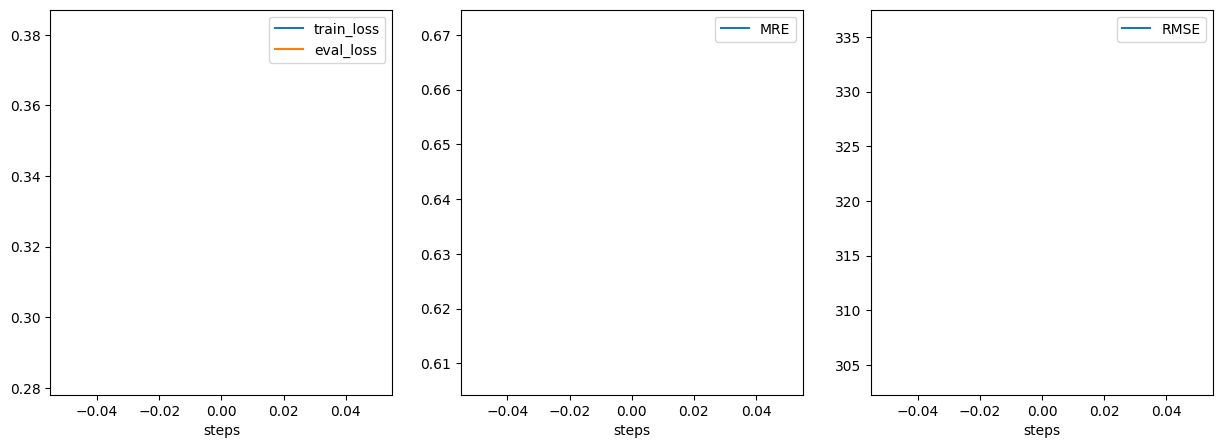

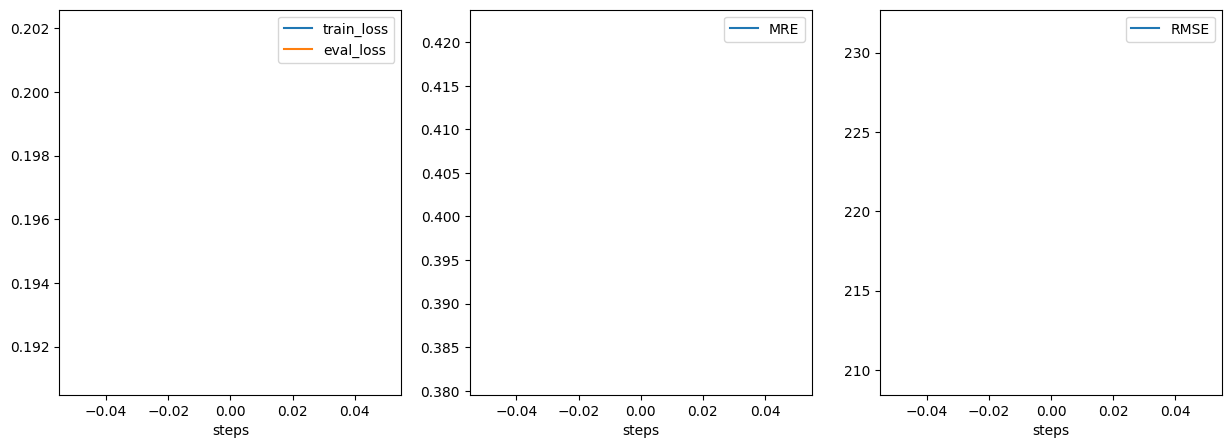

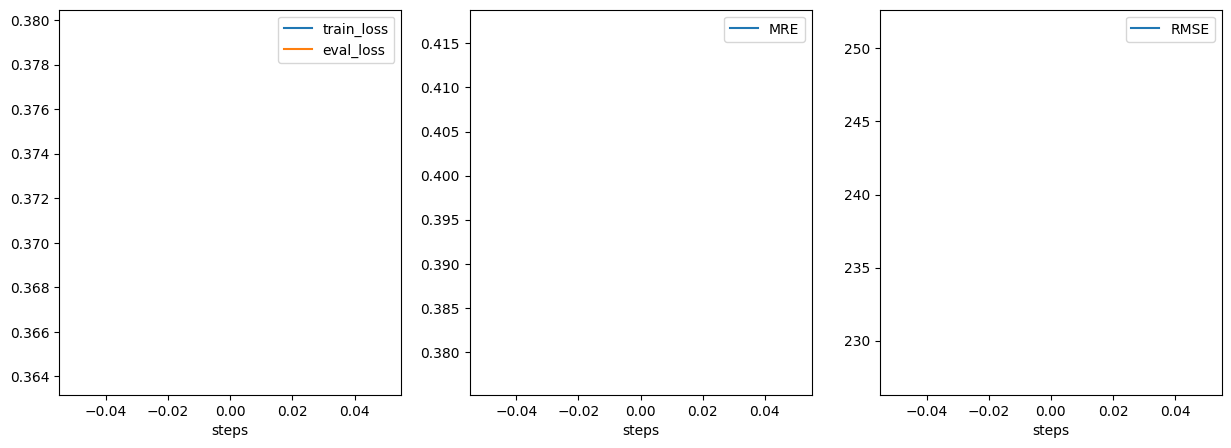

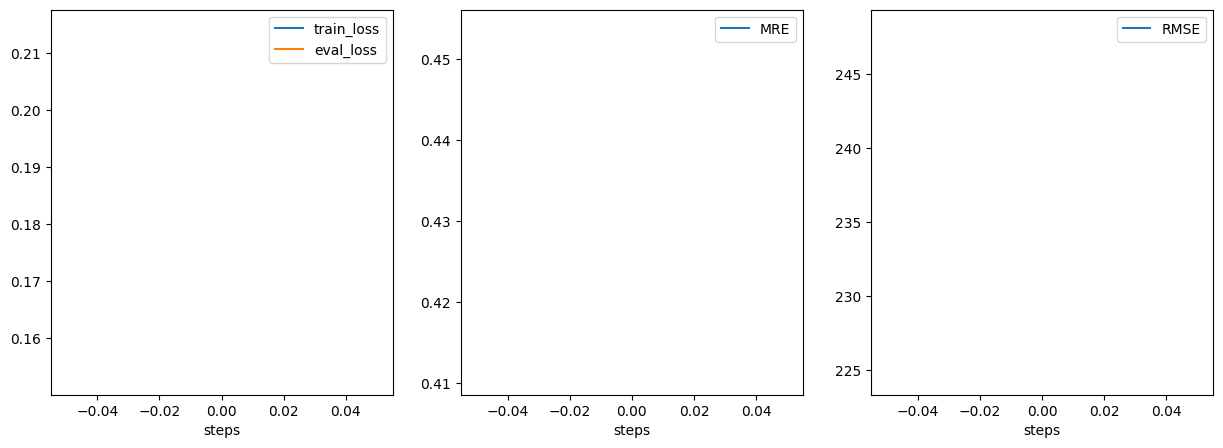

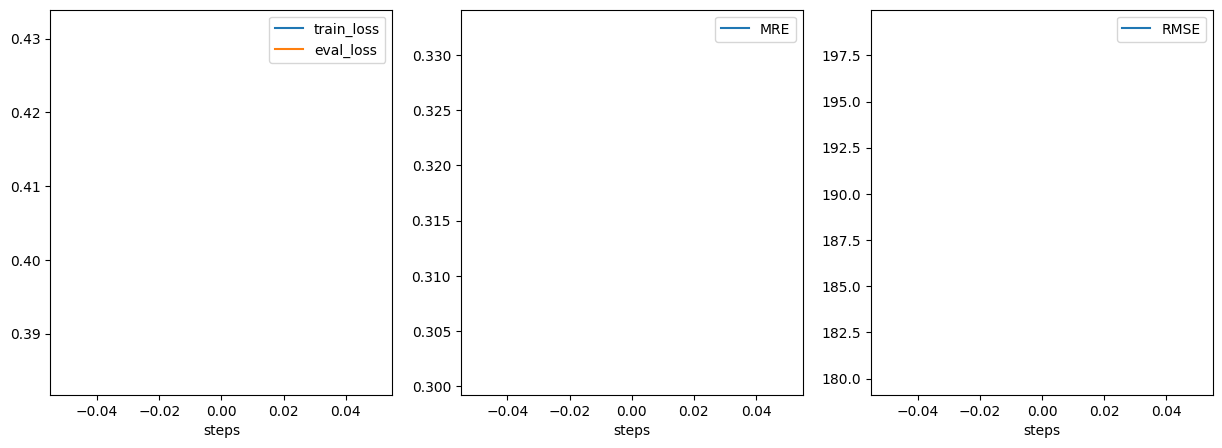

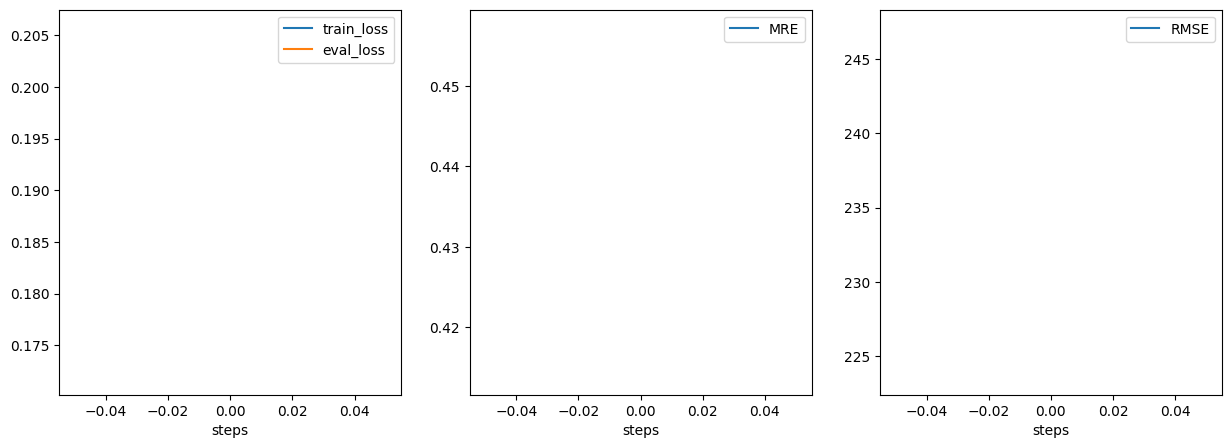

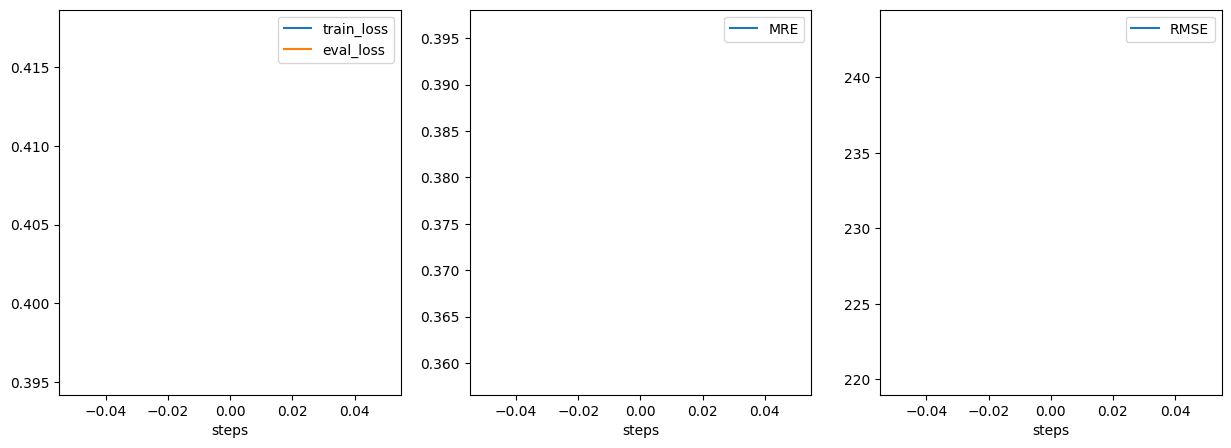

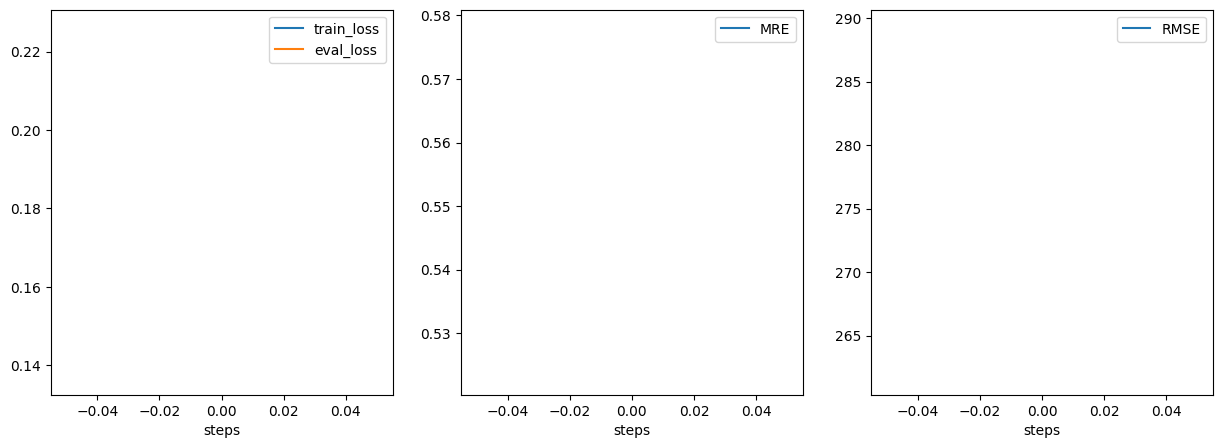

In [10]:

for i in range(len(transfer_configs)):
    conf = Config.from_dict({
        "model": "LSTM",
        "dataset_environment_str": dataset_environment_str,
        "meta_dataset_environment_strs": [dataset_environment_str],
        "dataset_subgraph_node_size": 12,
        "dataset_subgraph_step": 3,
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "model_params": {
            "num_layers": 4,
            "bidirectional": True
        },
        "dataset_dummy": False,
        "batch_size": 128,
        "eval_steps": eval_step,
        "learning_rate": 0.001,
        "epochs": epoch,
        "optimizer": "Adam",
        "train_size": train_size,
        "eval_size": eval_size,
        "transfer_params": transfer_configs[i],
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })

    model = torch.load(meta_model_path)
    print(model)
    model_type = ModelType.LSTM
    single_train_loop(model_type, conf, preprocessed_train_ds,
                      preprocessed_eval_ds, model, compute_evaluate_metrics, to_device, suffix="transfer")